### **Importamos paquetes y configuración general**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

from scipy import stats

# Plot settings
#sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'

plt.rcParams['figure.figsize'] = [10, 6]

from mpl_settings_v3 import *

### **Leemos dataset**

In [2]:
data_dir = './datasets'
data_file = os.path.join(data_dir, 'Telefonia_movil.csv')
data_raw = pd.read_csv(data_file, parse_dates=True, thousands='.')

## Creamos un indice con periodos trimestrales
data_raw.index = pd.PeriodIndex(
    ['{}Q{}'.format(anio, trimestre) for anio, trimestre in data_raw[['Año', 'Trimestre']].values],
    freq='Q'
)

data_raw.head()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
2013Q1,2013,1,8785943,6582117,15368060,Ene-Mar 2013
2013Q2,2013,2,9512689,7108640,16621329,Abr-Jun 2013
2013Q3,2013,3,10315484,7335154,17650638,Jul-Sept 2013
2013Q4,2013,4,9809515,6250549,16060064,Oct-Dic 2013
2014Q1,2014,1,10128751,5799223,15927974,Ene-Mar 2013


In [3]:
data = data_raw.copy()

## Descartamos columnas innecesarias
#data = data.drop(['Año', 'Trimestre', 'Periodo'], axis=1)

## Dividimos por 1E6 para mejor legibilidad y renombramos las columnas
data['Minutos pospago salientes (miles)'] /= 1E6
data['Minutos prepago salientes (miles)'] /= 1E6
data['Total de minutos salientes (miles)'] /= 1E6

col_dict = {
    'Minutos pospago salientes (miles)': 'Pospago (x1E9)',
    'Minutos prepago salientes (miles)': 'Prepago (x1E9)',
    'Total de minutos salientes (miles)': 'Total (x1E9)'
}

data = data.rename(columns=col_dict)
data.head()

,Año,Trimestre,Pospago (x1E9),Prepago (x1E9),Total (x1E9),Periodo
2013Q1,2013,1,8.785943,6.582117,15.368060,Ene-Mar 2013
2013Q2,2013,2,9.512689,7.108640,16.621329,Abr-Jun 2013
2013Q3,2013,3,10.315484,7.335154,17.650638,Jul-Sept 2013
2013Q4,2013,4,9.809515,6.250549,16.060064,Oct-Dic 2013
2014Q1,2014,1,10.128751,5.799223,15.927974,Ene-Mar 2013


## **Análisis exploratorio y visualización**

### **Time plots**

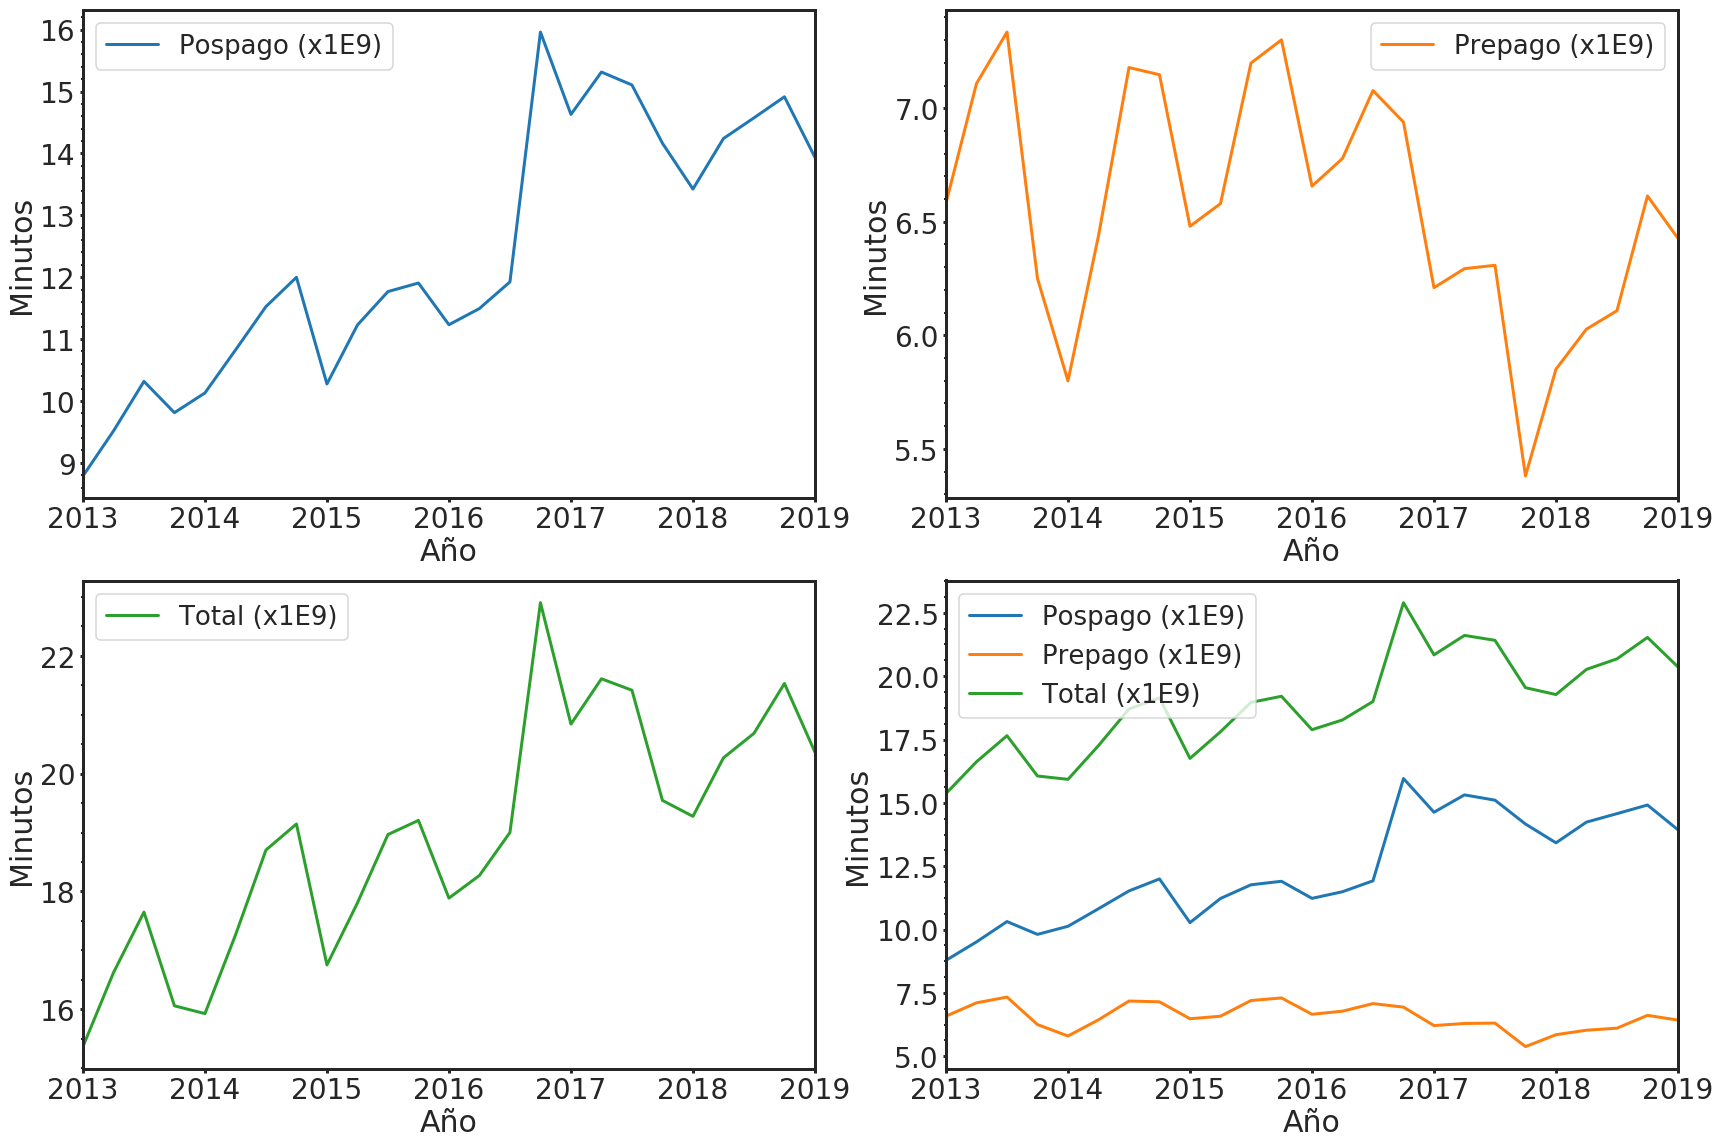

In [4]:
columns = [col for col in data.columns if '(x1E9)' in col]

ncols = 2
nrows= 2
fig, axes = plt.subplots(figsize=(12*ncols, 8*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()

for i in range(4):
    
    ax = axes[i]
    ax.set_xlabel('Año')
    ax.set_ylabel('Minutos')
    if i < 3:
        col = columns[i]
        data.plot(y=col, color=colors[i], ax=ax)
    else:
        data.plot(ax=ax, y=columns)
plt.tight_layout()
plt.show()

#### **Seasonal time plots**

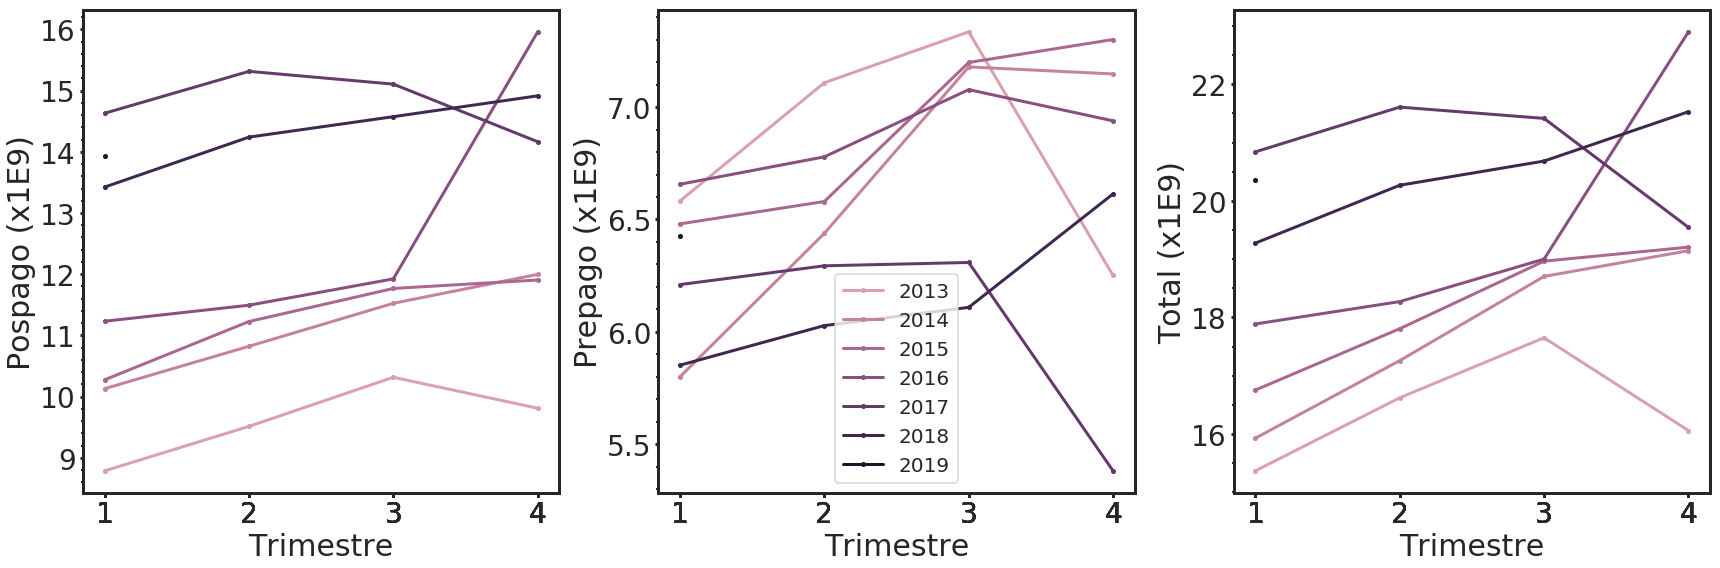

In [5]:
n_colors = data['Año'].unique().size
palette = sns.cubehelix_palette(n_colors, light=0.1, dark=0.7, reverse=True)

ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 8*nrows), ncols=3)

for i, (ax, col) in enumerate(zip(axes, columns)):
    ax.set_xticks(data.Trimestre)
    #ax.set_xticklabels(['{}'.format(i) for i in range(1, 5)])
    ax.set_xlabel('Trimestre')
    ax.set_ylabel(col)
    
    for j, year in enumerate(data['Año'].unique()):
        X = data[data['Año']==year].Trimestre
        Y = data[data['Año']==year][col]
        ax.plot(X, Y, '-o', color=palette[j], label=year, markersize=4)
        
    if i == 1:
        ax.legend(loc='best', fontsize=20)

plt.tight_layout()
#plt.savefig('seasonal.png')
plt.show()

El seasonal plot no parece dar información demasiado clara. Parece haber una tendencia creciente en los primeros tres trimestres, y un comportamiento bastante variado en el cuarto trimestre.

A partir de ahora, analizamos sólo el total de minutos salientes.

In [6]:
## Seleccionamos la columna asociada al total de minutos salientes
y = data.iloc[:,2]

#### **Lag plots**

Graficamos los lag plots para los intervalos de 1 a 4.

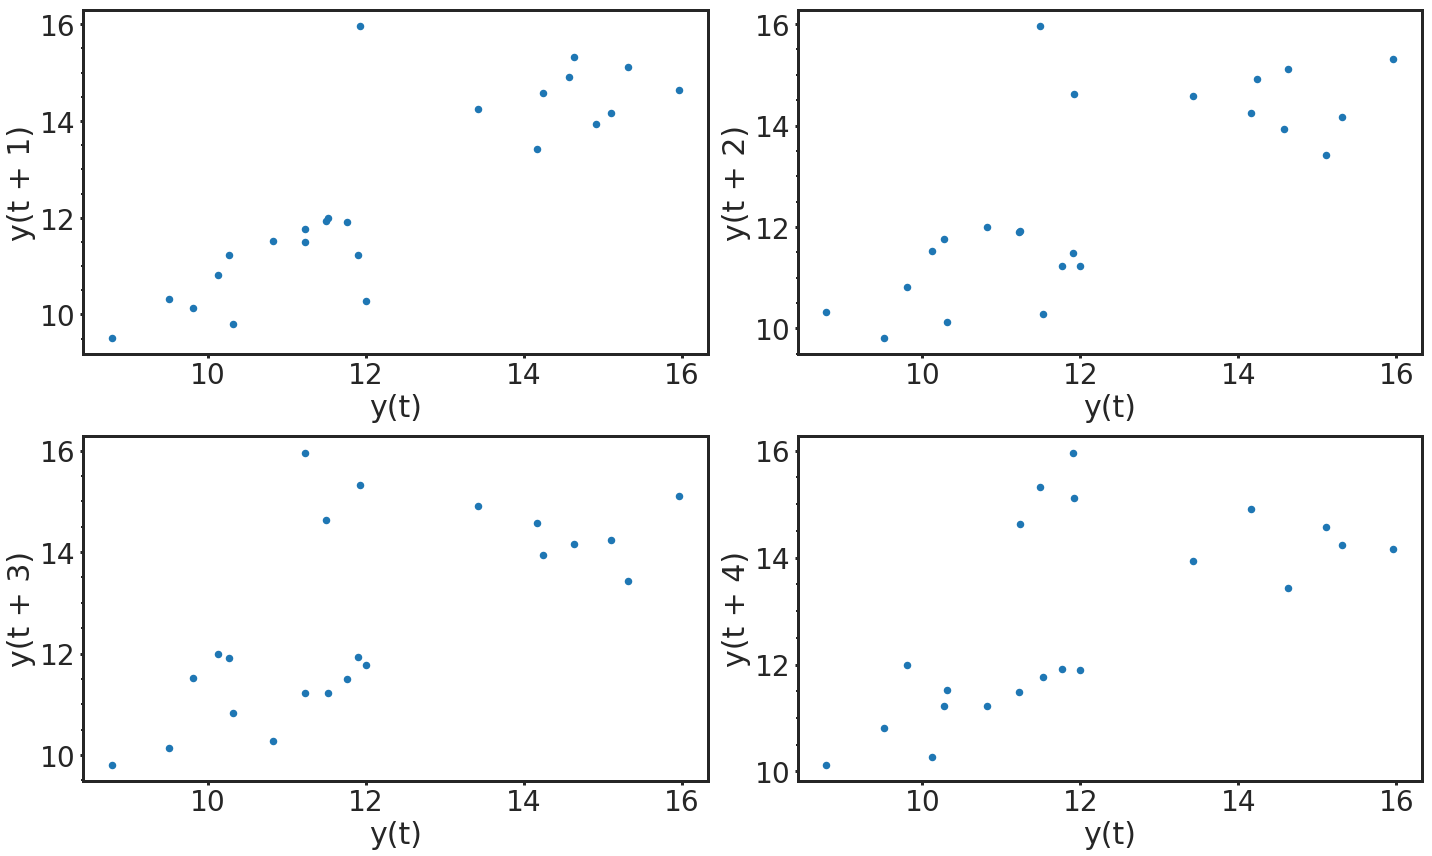

In [7]:
from pandas.plotting import lag_plot

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)
for i in range(4):
    ax = axes.flatten()[i]
    lag_plot(y, lag=i+1, ax=ax)
plt.tight_layout()
plt.show()

Si bien existe una correlación positiva en todos los lag plots, en ningún caso parece ser demasiado clara.

## **Modelos predictivos**

### **Random walk**

#### Análisis de residuos

In [8]:
resid = y - y.shift(1) # the shift lags the series by one period

In [9]:
resid.describe()

count    24.000000
mean      0.214639
std       1.111027
min      -1.723693
25%      -0.547997
50%       0.337422
75%       0.695254
max       4.037374
Name: Pospago (x1E9), dtype: float64

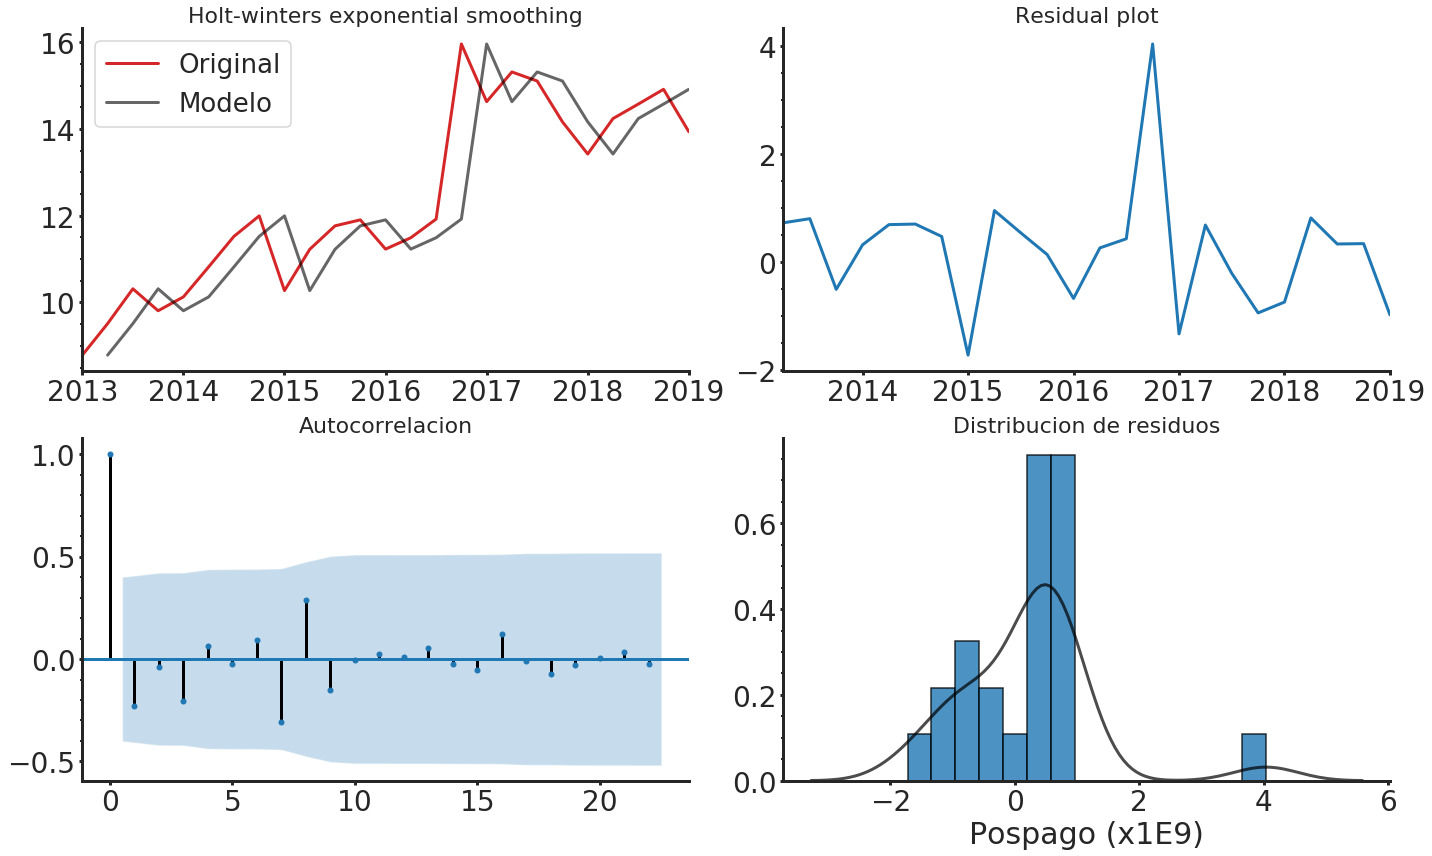

In [17]:
y_model = y.shift(1)
resid = (y - y_model)[1:] # the shift lags the series by one period

ncols = nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0,0]
y.plot(color='#D62728', ax=ax, label='Original')
y_model[1:].plot(color='black', label='Modelo', alpha=0.6, ax=ax)
ax.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=22)
sns.despine()

ax = axes[0,1]
resid.plot(ax=ax)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot', fontsize=22)
sns.despine()

ax = axes[1,0]
sm.graphics.tsa.plot_acf(resid, lags=22, ax=ax)
ax.set_title('Autocorrelacion', fontsize=22)
sns.despine()

ax = axes[1,1]
sns.distplot(resid, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': '#1F77B4'},  
             kde_kws={'color': 'black', 'alpha': 0.7}, bins=15)
sns.despine()
ax.set_title('Distribucion de residuos', fontsize=22)

plt.tight_layout()
#plt.savefig('lag_plot_calendar.png')
plt.show()

A pesar de que no existe autocorrelación significativa, los residuos están lejos de ser gaussianos, lo cual nos sugiere que el modelo de Random Walk no es suficiente para explicar el comportamiento de la serie temporal

#### Predicción usando Random Walk

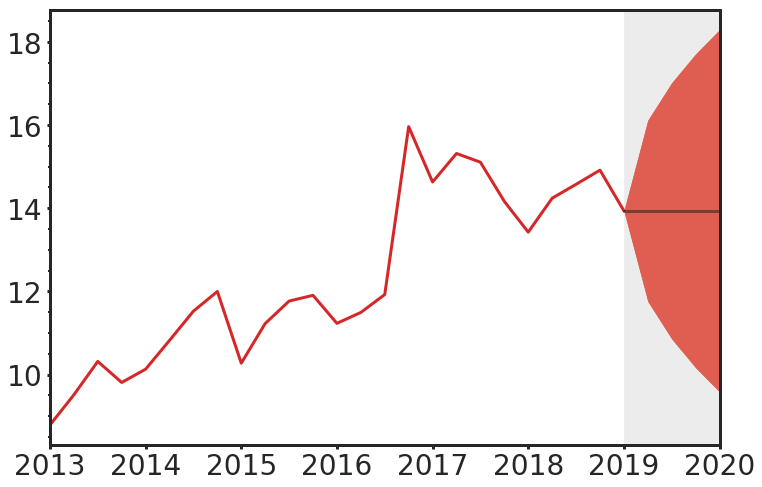

In [19]:
from plotting import fanchart

def fanchart(y, forecast, intv1, intv2, intv3, ax=None):
    assert type(y)==pd.core.series.Series, 'The time series must be a pandas series'
    assert type(forecast)==pd.core.series.Series, 'The forecast must be a pandas series'

    last=y.iloc[-1:]
    extended=last.append(forecast)

    with sns.axes_style('ticks'):
        if not ax:
            ax= plt.subplots(figsize=(8,5))
        y.plot(color='#D62728')
        extended.plot(color='black', alpha=0.4, label='Point forecast')
        ax.fill_between(extended.index, last.append(intv3.iloc[:,0]), last.append(intv3.iloc[:,1]), facecolor='#FAB8A4', lw=0)
        ax.fill_between(extended.index, last.append(intv2.iloc[:,0]), last.append(intv2.iloc[:,1]), facecolor='#F58671', lw=0)
        ax.fill_between(extended.index, last.append(intv1.iloc[:,0]), last.append(intv1.iloc[:,1]), facecolor='#F15749', lw=0)
        hold = ax.get_ylim()
        ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha=0.15)
        ax.set_ylim(hold)
    return ax

resid = y - y.shift(1) # the shift lags the series by one period
sigma = resid.std()

h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)

point_pred = (intv[0]+intv[1])/2

fig, ax = plt.subplots(figsize=(12, 8))
ax = fanchart(y, point_pred, intv, intv, intv, ax)

plt.show()

Visualmente podemos ver que la predicción no resulta muy informativa, dado que la incerteza que se maneja es del orden de la variación de la serie en toda la escala temporal.

### Exponential smoothing

In [25]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
y_model = model_ses.fittedvalues
model_ses.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,28.355
Optimized:,True,AIC,7.148
Trend:,None,BIC,9.586
Seasonal:,None,AICC,9.148
Seasonal Periods:,None,Date:,"Wed, 09 Oct 2019"
Box-Cox:,False,Time:,16:36:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7779804,alpha,True
initial_level,8.9825670,l.0,True


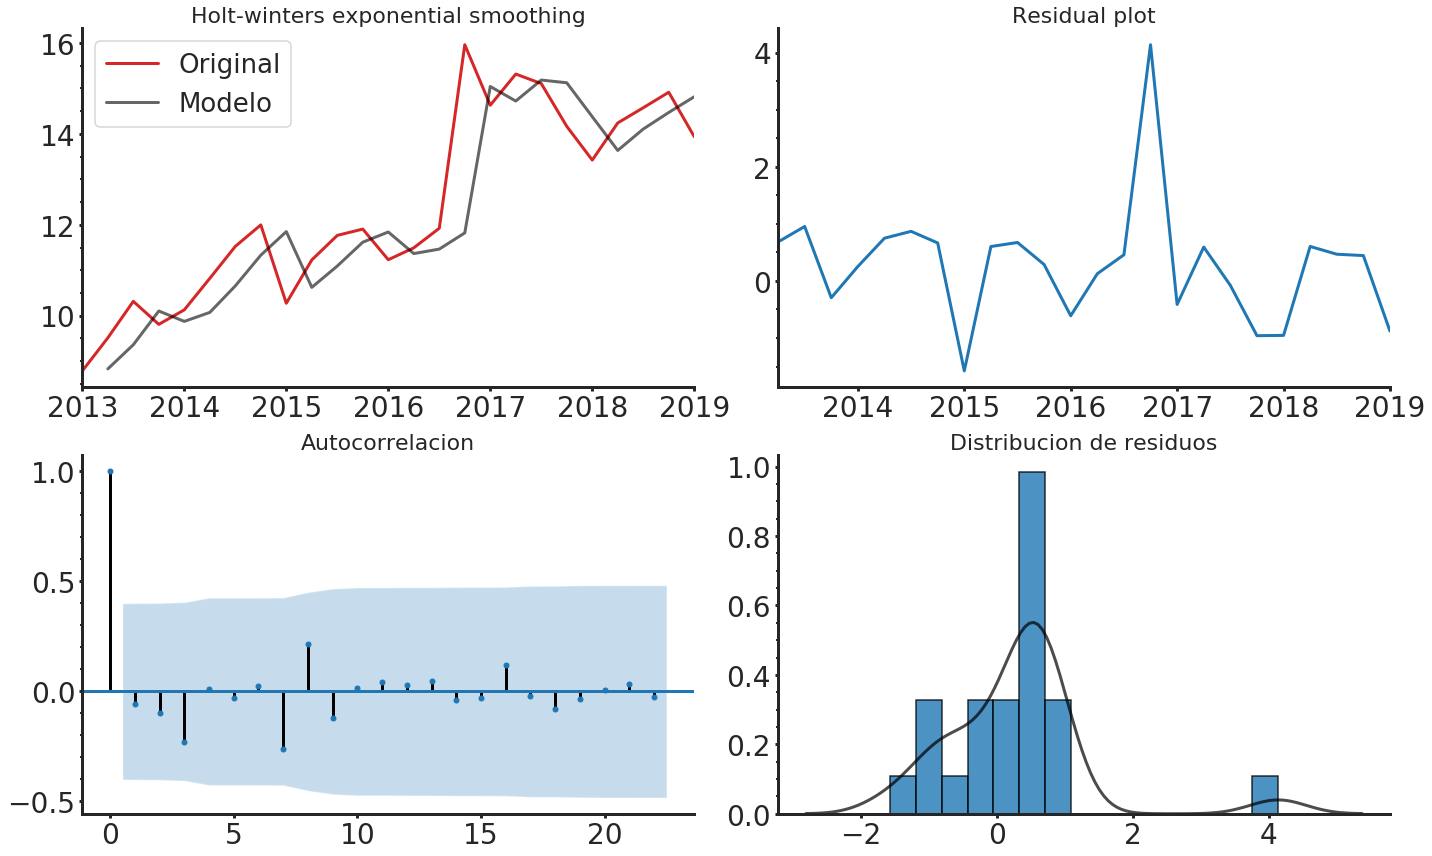

In [28]:
resid = (y - y_model)[1:] # the shift lags the series by one period

ncols = nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0,0]
y.plot(color='#D62728', ax=ax, label='Original')
y_model[1:].plot(color='black', label='Modelo', alpha=0.6, ax=ax)
ax.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=22)
sns.despine()

ax = axes[0,1]
resid.plot(ax=ax)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot', fontsize=22)
sns.despine()

ax = axes[1,0]
sm.graphics.tsa.plot_acf(resid, lags=22, ax=ax)
ax.set_title('Autocorrelacion', fontsize=22)
sns.despine()

ax = axes[1,1]
sns.distplot(resid, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': '#1F77B4'},  
             kde_kws={'color': 'black', 'alpha': 0.7}, bins=15)
sns.despine()
ax.set_title('Distribucion de residuos', fontsize=22)

plt.tight_layout()
#plt.savefig('lag_plot_calendar.png')
plt.show()

### **Comparación entre modelos**

In [29]:
# Real time forecasting - use it as a template - expanding window

start_date = '2017Q1'
train=y[:start_date].index          # entrenamiento termina en periodo Q1 2013
validation=y[start_date:].index     # validacion comienza en periodo Q1 2017 en adelante
start = y.index.get_loc(start_date)

print('Train samples      =', train.shape[0])
print('Validation samples =', validation.shape[0])

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

Train samples      = 17
Validation samples = 9


,RW,SES,Actual
2018Q1,14.164552,14.381417,13.423580
2018Q2,13.423580,13.597805,14.240217
2018Q3,14.240217,14.107254,14.574305
2018Q4,14.574305,14.476280,14.915060
2019Q1,14.915060,14.828009,13.937271


#### **Error cuadrático medio**

In [31]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(4)

,RMSE,SE
RW,0.7867,0.2665
SES,0.7882,0.2666


Para este conjunto de datos en particular, no se aprecia diferencia significativa entre random walk y exponential smoothing.